                 날짜     평균기온(℃)   평균풍속(m/s)     강수량(mm)        강수유무  \
count  3.650000e+02  365.000000  365.000000  365.000000  365.000000   
mean   2.017067e+07   14.370878    1.678510    3.129461    0.293151   
std    3.454755e+02   11.150654    0.501188   13.539250    0.455832   
min    2.017010e+07   -8.952381    0.769231    0.000000    0.000000   
25%    2.017040e+07    3.900000    1.352000    0.000000    0.000000   
50%    2.017070e+07   16.344000    1.584000    0.000000    0.000000   
75%    2.017100e+07   24.027273    1.955000    0.275000    1.000000   
max    2.017123e+07   33.410000    3.161905  149.318182    1.000000   

        미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)         전체이용객  
count  365.000000  365.000000    365.000000  
mean    45.479301   25.634493  13783.646575  
std     23.998045   14.539660   9341.533060  
min      6.916667    4.333333      9.000000  
25%     28.083333   15.375000   5740.000000  
50%     41.625000   22.750000  12602.000000  
75%     56.083333   32.791667  19419.0

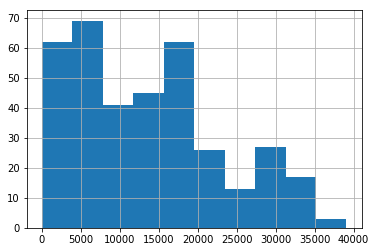

25.0    59
4.0     28
5.0     20
20.0    20
7.0     19
8.0     19
19.0    18
3.0     17
18.0    16
2.0     15
11.0    15
13.0    15
14.0    13
17.0    11
16.0    11
12.0    10
9.0     10
6.0     10
10.0     8
15.0     7
21.0     7
23.0     6
22.0     5
1.0      4
24.0     2
Name: 전체, dtype: int64


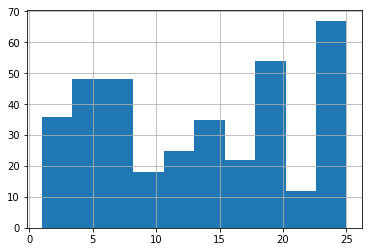

전체이용객         1.000000
평균기온(℃)       0.621824
날짜            0.561724
강수유무         -0.148025
평균풍속(m/s)    -0.154643
강수량(mm)      -0.167976
미세먼지(㎍/㎥)    -0.323301
초미세먼지(㎍/㎥)   -0.355745
Name: 전체이용객, dtype: float64
평균 하루 이용객  13792.256849315068
--------------------------------------------------
선형모델 rmse :  4913.283372498518
결정트리 rmse :  0.0
랜덤모델 rmse :  1234.1206404167867
sgd rmse :  4927.785330259634
다항 회귀 선형모델 rmse :  2066.0082687344675
-------------------------------------------------------------
평균 :  5032.525022764214
표준편차 :  560.6542436670865
-------------------------------------------------------------
-------------------------------------------------------------
평균 :  4097.691352646918
표준편차 :  1188.6184677077879
-------------------------------------------------------------
-------------------------------------------------------------
평균 :  3129.792397021775
표준편차 :  486.72568881649374
-------------------------------------------------------------
-----------------------------------

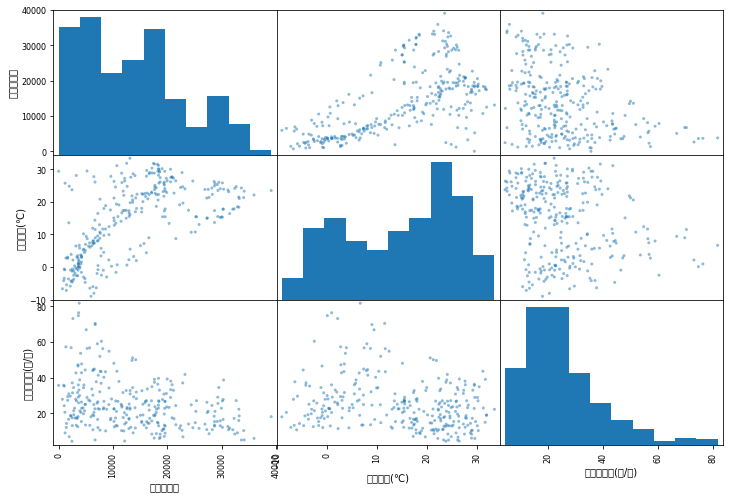

In [25]:

# 작성자 : 이민우
# 작성일 : 20181119 ~ 
# 프로그램설명 : 머신러닝을 이용한 날씨 및 미세머지와 외출의 관계 예측
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


import datetime

import warnings

warnings.filterwarnings('ignore')




    
def load_xlsx_data(filename, test_path = "datasets3"): # 주어진 filename 을 읽는 함수
    xlsx_path = os.path.join(test_path,filename)
    return pd.read_excel(xlsx_path)

def combineNum(temp): # 대여소별 -> 요일별 같은 요일끼리 묶는다.
    df = pd.DataFrame(columns=temp.columns) # 공백 데이터프레임 생성 
    df = df.astype({'대여 일자 / 월': float}) # 공백 데이터 프레임의 대여 일자 /월 컬럼 데이터 타입 변경
    temp.sort_values(by='대여 일자 / 월', inplace=True) # 혹시 가져온 데이터 셋이 정렬이 안되있을도 있으니 정렬
    temp = temp.reset_index(drop=True) # 정렬할 때 인덱스 번호는 적용이 안된다. 따라서 인덱스 번호를 초기화 해준다.
    sum1 = 0 
    date = 20170101 # 시작 일 
  
    for i in range(len(temp)):
        if temp["대여 일자 / 월"][i] == date: # 같은 날일때 이용자수 합 
            sum1 += temp['대여 건수'][i]
            
            if i==len(temp)-1: # 마지막날

                li = [date,sum1]

                date = temp["대여 일자 / 월"][i]
                sum1 = temp['대여 건수'][i]

                df.loc[len(df)] =li 
        else:
            li = [date,sum1] 
            date = temp["대여 일자 / 월"][i]
            sum1 = temp['대여 건수'][i]
            
            df.loc[len(df)] =li  # 공백 데이터 프레임에 열 추가
        
    #df.to_excel('datasets3/tempAve2.xlsx', sheet_name='sheet1')   # 엑셀 파일로 저장
    return df    


def combineObs(temp): # 같은 요일끼리 묶어주는 함수 기존에는 구역별로 나누어져 있다.
    df = pd.DataFrame(columns=temp.columns,dtype = 'float') # 공백 데이터프레임 생성 

    temp.sort_values(by='관측일자', inplace=True) # 데이터 셋이 정렬 안돼있을 경우 생각 
    temp = temp.reset_index(drop=True) # 인덱스 번호 초기화

    sum1 = 0 
    sum2 = 0 
    sum3 = 0
    cnt = 0
    
    date = 20170101 # 시작날 
 
    for i in range(len(temp)):
        if temp["관측일자"][i] == date: # 같은 날일때 지역 상관없이 날씨의 합 
            sum1 += temp['평균기온(℃)'][i]
            sum2 += temp['평균풍속(m/s)'][i]
            sum3 += temp['강수량(mm)'][i]
            cnt = cnt + 1
            
            if i==len(temp)-1: # 마지막날
                if sum3 > 0: # 강수 유무
                    sum4 = 1
                else:
                    sum4 = 0
                li = [date,sum1/cnt,sum2/cnt,sum3/cnt,sum4] 

                date = temp["관측일자"][i]
            
                sum1 = temp['평균기온(℃)'][i]
                sum2 = temp['평균풍속(m/s)'][i]
                sum3 = temp['강수량(mm)'][i]

                df.loc[len(df)] =li
          
        else:
            if sum3 > 0: # 강수 유무 ( 강수량이 0 이상이면 강수 유무 1)
                sum4 = 1
            else:
                sum4 = 0
            li = [date,sum1/cnt,sum2/cnt,sum3/cnt,sum4] # 평균 
            
            
            date = temp["관측일자"][i]
            
            sum1 = temp['평균기온(℃)'][i]
            sum2 = temp['평균풍속(m/s)'][i]
            sum3 = temp['강수량(mm)'][i]
            
            df.loc[len(df)] =li # 공백 데이터 프레임에 추가 
            cnt = 0
   
    return df    
 
    
def combineAve(temp): # 같은 요일끼리 묶어주는 함수 기존에는 구역별로 나누어져 있다.
    
    df = pd.DataFrame(columns=temp.columns) # 공백 데이터프레임 생성 
    
    temp.sort_values(by='측정일자', inplace=True) # 정렬이 안되있을 경우 고려 
    temp = temp.reset_index(drop=True) # 정렬 시 인덱스 번호 초기화 
   
    
    sum1 = 0 
    sum2 = 0 
   
    cnt = 0
    
    date = 20170101 # 시작날 
 
    for i in range(len(temp)):
        if temp["측정일자"][i] == date: # 같은 날일때 지역 상관없이 대기환경의 합
            sum1 += temp['미세먼지(㎍/㎥)'][i]
            sum2 += temp['초미세먼지(㎍/㎥)'][i]
        
            cnt = cnt + 1
            
            if i==len(temp)-1: # 마지막날
                li = [date,sum1/cnt,sum2/cnt] 

                date = temp["측정일자"][i]
            
                sum1 = temp['미세먼지(㎍/㎥)'][i]
                sum2 = temp['초미세먼지(㎍/㎥)'][i]
               
                df.loc[len(df)] =li
          
        else:

            li = [date,sum1/cnt,sum2/cnt] # 평균 
            
            
            date = temp["측정일자"][i]
            
            sum1 = temp['미세먼지(㎍/㎥)'][i]
            sum2 = temp['초미세먼지(㎍/㎥)'][i]
            
            df.loc[len(df)] =li # 공백 데이터 프레임에 추가 
            cnt = 0
  
    return df    
 
 
    
    
def Design(Number,observation,Average):# 데이터 통합 과정
   
    for i in Number.columns[0:2]: # 쓸모없는 특성 제거
        Number = Number.drop(i,axis = 1)
        
    del observation["지점명"]  # 쓸모없는 특성 제거 
    del observation["최저기온(℃)"]
    del observation["최대기온(℃)"]
    del observation["평균습도(%)"]
    del observation["최저습도(%)"]
    del observation["최고습도(%)"]
    del observation["최대풍속(m/s)"]
    
    observation["강수유무"] = 0 # 데이터 프레임 초기화 (새로운 특성)
    
    del Average["권역명"]
    del Average["측정소명"]
    
    for i in Average.columns[3:]: # 쑬모없는 특성제거 
        Average = Average.drop(i,axis = 1)
    

    
    
    Number = combineNum(Number)
    observation = combineObs(observation)
    Average = combineAve(Average)
    
   
    # 비교를 위해 모든 데이터프레임 날짜에 해당하는 칼럼 자료형 통일 
    Number = Number.astype({"대여 일자 / 월": np.int64})
    observation = observation.astype({"관측일자": np.int64})
    Average = Average.astype({"측정일자": np.int64})
    
    
    # 통합된 데이터셋을 담을 데이터 프레임 
    All_set = pd.DataFrame(columns=("날짜", "평균기온(℃)","평균풍속(m/s)","강수량(mm)","강수유무","미세먼지(㎍/㎥)","초미세먼지(㎍/㎥)"
                                    ,"전체이용객") , dtype = 'float') 
    li = []
    li2 = []
    li3 = []
    li4 = []
    li5 = []
    li6 = []
    
    i = 0
    
    # 대여량 데이터셋과 관측 데이터 셋 연결 
    while i < len(Number):
        if Number.iloc[i][0] == observation.iloc[i][0]: #날짜가 같을시 매칭 
            li.append(observation.iloc[i][1])
            li2.append(observation.iloc[i][2])
            li3.append(observation.iloc[i][3])
            li4.append(observation.iloc[i][4])

            
        else: # 다를시 둘 중 빈곳을 전날 데이터로 채움 
            if Number.iloc[i][0] < observation.iloc[i][0]: #  observation 데이터셋이 결측값이 있을때 날짜가 건너뛰니 숫자가 커짐 
                    temp = [Number.iloc[i][0] ,observation.iloc[i-1][1]
                            ,observation.iloc[i-1][2],observation.iloc[i-1][3],observation.iloc[i-1][4]]
                    observation.loc[len(observation)] = temp
                    observation.sort_values(by='관측일자', inplace=True) # 전날 데이터로 채워 넣음
                    observation = observation.reset_index(drop=True)

            else: #  Number 데이터셋이 결측값이 있을때
                    temp = [observation.iloc[i][0],Number.iloc[i-1][1]]
                    Number.loc[len(Number)] = temp
                    Number.sort_values(by='대여 일자 / 월', inplace=True)
                    Number = Number.reset_index(drop=True)
           
            i = i-1
        i = i + 1
    
    i = 0
      
    while i < len(Number): #대여랑대이터 셋과 미세먼지 데이터 셋 매칭 
        if Number.iloc[i][0] == Average.iloc[i][0]:
            li5.append(Average.iloc[i][1]) # 날짜가 같을시 매칭 
            li6.append(Average.iloc[i][2])
        else: # 다를 시 빈 날짜를 전날 데이터로 채워줌
            if Number.iloc[i][0] < observation.iloc[i][0]: #  observation 데이터셋이 결측값이 있을때 날짜가 건너뛰니 숫자가 커짐 
                    temp = [Number.iloc[i][0] ,Average.iloc[i-1][1]
                            ,Average.iloc[i-1][2]]
                    Average.loc[len(observation)] = temp
                    Average.sort_values(by='측정일자', inplace=True) # 전날 데이터로 채워 넣음
                    Average = observation.reset_index(drop=True)

            else:  #Number 데이터셋이 결측값이 있을때
                    temp = [Average.iloc[i][0],Number.iloc[i-1][1]]
                    Number.loc[len(Number)] = temp
                    Number.sort_values(by='대여 일자 / 월', inplace=True)
                    Number = Number.reset_index(drop=True)
            i = i-1
        i = i + 1
    
    
    # 새로운 데이터 프레임에 매칭 시킨 정보들 담는다.
    
    All_set["날짜"] = Number["대여 일자 / 월"]
    All_set["전체이용객"] = Number["대여 건수"]
    
   
    All_set["평균기온(℃)"] = li
    All_set["평균풍속(m/s)"] = li2
    All_set["강수량(mm)"] = li3
    All_set["강수유무"] = li4
    All_set["미세먼지(㎍/㎥)"] = li5
    All_set["초미세먼지(㎍/㎥)"] = li6
   
    """
    day = []
    cnt = 7
    for i in range(365):
        if cnt == 6 :
            day.append(1)
        elif cnt == 7:
            day.append(1)
            cnt = 0
        else:
            day.append(0)
        cnt = cnt+1
    
    All_set["토,일"] = day
    """
    
    return All_set
    
def display_score(sco): # 보기 쉽게 점수를 출력 
    print("-------------------------------------------------------------")
    print("평균 : ", sco.mean())
    print("표준편차 : ", sco.std())
    print("-------------------------------------------------------------")
    
if __name__ == "__main__":
    # data load
    Number = load_xlsx_data("대여소별 대여내역(2017년).xlsx")
    observation = load_xlsx_data('일별기상관측_2017.xlsx')
    Average = load_xlsx_data('기간별_일평균_대기환경_정보_2017년.xlsx')
    
   # print(Number.info())
   # print(observation.info())
   # print(Average.info())
    
    #print(Number.describe())
    #print(observation.describe())
    #print(Average.describe())
    
    
    
    All_set = Design(Number,observation,Average) # 데이터 통합
    
  
    #print(All_set.hist())
   # plt.show()
    #All_set = All_set.astype({"날짜": object})
    print(All_set.describe()) # 수치형 특성 요약 
    print('최소 이용객 ' ,All_set["전체이용객"].min()) # 정답 레이블 최솟값
    print('최대 이용객 ' ,All_set["전체이용객"].max()) # 정답 래이블 최대값 
    print(All_set.info()) # 최종 데이터 셋 정보 
    
    #All_set["전체이용객"].hist() 
    #plt.show()
    
    All_set["전체"] = np.ceil(All_set["전체이용객"] / 1000) # 계층적 샘플링을 위한 준비 
    
    All_set["전체"].where(All_set["전체"] < 25, 25, inplace=True)
    All_set["전체"].hist()
   # print(All_set["전체"].value_counts())
   # plt.show()
   
  
    # 계층적 샘플링 
    train_set, test_set = train_test_split(All_set, test_size = 0.2, stratify = All_set["전체"])
    
    
    for set_ in (train_set, test_set):
        set_.drop("전체", axis=1, inplace=True)
    
    # 정답 레이블 분리 
    train_copy = train_set.copy()
    train = train_set.drop("전체이용객", axis=1)
    train_labels = train_set["전체이용객"].copy()
    
    # 상관계수 출력 
    corr_matrix = train_copy.corr()
    print(corr_matrix["전체이용객"].sort_values(ascending = False))
    
    # 상관계수 scatter_matrix 로 출력 
    from pandas.plotting import scatter_matrix
    att = ['전체이용객','평균기온(℃)','초미세먼지(㎍/㎥)']
    scatter_matrix(train_copy[att] , figsize = (12,8))
    plt.plot()
    
    # 정규화
    scaler = StandardScaler()
    
    
    train_prepared = scaler.fit_transform(train)
    
    print("평균 하루 이용객 " , train_labels.mean())
    print("--------------------------------------------------")
    
    
    # 선형모델 rmse 실험 
    lin_reg = LinearRegression() # 선형모델 생성 
    lin_reg.fit(train_prepared,train_labels) # 학습 
    lin_prediction = lin_reg.predict(train_prepared) # 선형모델로 예측한 값 
    lin_mse = mean_squared_error(train_labels, lin_prediction) # 예측한 값과 레이블의 차이
    lin_rmse = np.sqrt(lin_mse) # 차이에 root 
    print("선형모델 rmse : ",lin_rmse)
    
    # 결정트리 rmse 실험 
    tre_reg = DecisionTreeRegressor() # 결정트리모델 생성 
    tre_reg.fit(train_prepared,train_labels) # 학습 
    tre_prediction = tre_reg.predict(train_prepared) # 결정트리로 예측한 값 
    tre_mse = mean_squared_error(train_labels, tre_prediction) # 예측한 값과 레이블의 차이 
    tre_rmse = np.sqrt(tre_mse) 
    print("결정트리 rmse : ",tre_rmse)
    
    # 랜덤포레스트모델 (앙상블 기법)
    fo_reg = RandomForestRegressor() # 모델 생성 
    fo_reg.fit(train_prepared, train_labels) # 모델 학습 
    fo_prediction = fo_reg.predict(train_prepared) # 모델로 예측값 도출
    fo_mse = mean_squared_error(train_labels, fo_prediction) # mse 값 
    fo_rmse = np.sqrt(fo_mse) # rmse 값 
    print("랜덤모델 rmse : ",fo_rmse)
    
    
    # 확률적 경사 하강법 
    from sklearn.linear_model import SGDRegressor
    sgd_reg = SGDRegressor(max_iter = 50, penalty = None, eta0 = 0.1 ,random_state = 42)
    sgd_reg.fit(train_prepared,train_labels)
    sgd_prediction = sgd_reg.predict(train_prepared) # 선형모델로 예측한 값 
    sgd_mse = mean_squared_error(train_labels, sgd_prediction) # 예측한 값과 레이블의 차이
    sgd_rmse = np.sqrt(sgd_mse) # 차이에 root 
    print("sgd rmse : ",sgd_rmse)
    
    # 다항 회귀 
    from sklearn.preprocessing import PolynomialFeatures
    poly_features = PolynomialFeatures(degree = 3, include_bias = False) # 차수 3 
    X_poly = poly_features.fit_transform(train_prepared) # 3차로 번형 
    
    plin_reg = LinearRegression() # 선형모델 생성 (다항으로 사용 )
    plin_reg.fit(X_poly,train_labels) # 학습 
    plin_prediction = plin_reg.predict(X_poly) # 선형모델로 예측한 값 
    plin_mse = mean_squared_error(train_labels, plin_prediction) # 예측한 값과 레이블의 차이
    plin_rmse = np.sqrt(plin_mse) # 차이에 root 
    print("다항 회귀 선형모델 rmse : ",plin_rmse)
    
 
    
     # 교차검증을 사용한 평가. 
    # mse 가 아닌 nmse 를 사용 
    # 선형모델의 경우 2, 결정트리,랜덤포레스트 10 의 cv 를 사용 
  
    # cv = 10 교차검증 
    scores = cross_val_score(lin_reg, train_prepared, train_labels,scoring = "neg_mean_squared_error", cv = 10)
    lin_rmse_score = np.sqrt(-scores)
    display_score(lin_rmse_score)
    
    scores = cross_val_score(tre_reg,train_prepared, train_labels,scoring = "neg_mean_squared_error", cv = 10)
    tre_rmse_score = np.sqrt(-scores)
    display_score(tre_rmse_score)
    
    scores = cross_val_score(fo_reg,train_prepared, train_labels,scoring = "neg_mean_squared_error", cv = 10)
    fo_rmse_score = np.sqrt(-scores)
    display_score(fo_rmse_score)
    
    scores = cross_val_score(sgd_reg,train_prepared, train_labels,scoring = "neg_mean_squared_error", cv = 10)
    sgd_rmse_score = np.sqrt(-scores)
    display_score(sgd_rmse_score)
    
    scores = cross_val_score(plin_reg,X_poly, train_labels,scoring = "neg_mean_squared_error", cv = 10)
    plin_rmse_score = np.sqrt(-scores)
    display_score(plin_rmse_score)
    
    from sklearn.model_selection import GridSearchCV 
    # 그리드 탐색 
    li = [i for i in range(1,50,1)]
    li2 = [i*0.01 for i in li]
    param_grid = [
        {'n_estimators':li,'max_features':li2},
        {'bootstrap':[False],'n_estimators':li,'max_features':li2},    
    ]
    
    grid_search = GridSearchCV(fo_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error',
                                return_train_score = True)
    grid_search.fit(train_prepared, train_labels)
    
  
    
    final_model = grid_search.best_estimator_ #  그리드 탐색 최적의 결과 = 최종모델 
    
    
    
    test = test_set.copy() # 최종 test set 
    test_labels = test['전체이용객'].copy() # 정답 레이블 분리 
    test = test.drop('전체이용객',axis = 1)
    
    test_prepared = scaler.transform(test) # 데이터 정제 
   
    
    lin_prediction = lin_reg.predict(test_prepared) # 선형모델로 예측한 값 
    lin_mse = mean_squared_error(test_labels, lin_prediction) # 예측한 값과 레이블의 차이
    lin_rmse = np.sqrt(lin_mse) # 차이에 root 
    print("선형모델 rmse : ",lin_rmse)
    
  
    tre_prediction = tre_reg.predict(test_prepared) # 결정트리로 예측한 값 
    tre_mse = mean_squared_error(test_labels, tre_prediction) # 예측한 값과 레이블의 차이 
    tre_rmse = np.sqrt(tre_mse) 
    print("결정트리 rmse : ",tre_rmse)
    
  
    fo_prediction = fo_reg.predict(test_prepared) # 모델로 예측값 도출
    fo_mse = mean_squared_error(test_labels, fo_prediction) # mse 값 
    fo_rmse = np.sqrt(fo_mse) # rmse 값 
    print("랜덤모델 rmse : ",fo_rmse)
    
    sgd_prediction = sgd_reg.predict(test_prepared) # 선형모델로 예측한 값 
    sgd_mse = mean_squared_error(test_labels, sgd_prediction) # 예측한 값과 레이블의 차이
    sgd_rmse = np.sqrt(sgd_mse) # 차이에 root 
    print("sgd rmse : ",sgd_rmse)




    final_predictions = final_model.predict(test_prepared) #최종 모델로 예측 
    final_mse = mean_squared_error(test_labels, final_predictions)
    final_rmse = np.sqrt(final_mse)
    
    print("최종 rmse", final_rmse) # 최종 rmse 값 일반적으로 교차검증을 사용할때보다 크게나옴 
    
